<a href="https://colab.research.google.com/github/chaurasiauttkarsh/Natural-Language-Processing/blob/master/Headline_Sarcasm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing the Libraries**

In [1]:
import tensorflow as tf
print(tf.__version__)

# To install tensorflow 2.0
# !pip install tensorflow==2.0.0-beta0

# If tensorflow version is less than 2.0.0
tf.enable_eager_execution()

# To install tensorflow dataset library : !pip install -q tensorflow-datasets

1.15.0


**Loading the Data**


In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-03-22 08:29:21--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2020-03-22 08:29:21 (177 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



Extracting the labels and headline from loaded dataset

In [0]:
import json

with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [0]:
training_size = 20000

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
print(training_labels[:2], training_sentences[:2])

[0, 0] ["former versace store clerk sues over secret 'black code' for minority shoppers", "the 'roseanne' revival catches up to our thorny political mood, for better and worse"]


**Preprocessing the data**

```
hyperparameters
```



In [0]:
vocab_size = 10000
embedding_dim = 16
padding_type='post'
max_length = 100
trunc_type='post'
oov_token = "OOV"

Padding the data

In [0]:
# Importing the Libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fitting the tokenizer on training data
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [0]:
import numpy as np
training_padded = np.array(padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [15]:
print(training_labels[:1], training_padded[:1],'\n', testing_labels[:1], testing_padded[:1])

[0] [[ 328    1  799 3405 2404   47  389 2214    1    6 2614 8863    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]] 
 [1] [[   1 1100 6663 9423   30    1 2439    5  519  109    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    

Decoding the Padded Sentence

In [17]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_headline(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_headline(training_padded[1]))
print(training_sentences[1])

the 'roseanne' revival catches up to our OOV political mood for better and worse ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
the 'roseanne' revival catches up to our thorny political mood, for better and worse


**Creating the Model**

In [27]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(24, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')])
model.compile(loss='binary_crossentropy', optimizer='adam', metrices=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


Training corpus

In [28]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,verbose = 1, validation_data=(testing_padded, testing_labels))

Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 [==============================] - 3s 168us/sample - loss: 0.6682 - val_loss: 0.5983
Epoch 2/30
20000/20000 [==============================] - 3s 148us/sample - loss: 0.4352 - val_loss: 0.3814
Epoch 3/30
20000/20000 [==============================] - 3s 151us/sample - loss: 0.3046 - val_loss: 0.3566
Epoch 4/30
20000/20000 [==============================] - 3s 147us/sample - loss: 0.2523 - val_loss: 0.3537
Epoch 5/30
20000/20000 [==============================] - 3s 148us/sample - loss: 0.2179 - val_loss: 0.3548
Epoch 6/30
20000/20000 [==============================] - 3s 149us/sample - loss: 0.1910 - val_loss: 0.3552
Epoch 7/30
20000/20000 [==============================] - 3s 148us/sample - loss: 0.1708 - val_loss: 0.3713
Epoch 8/30
20000/20000 [==============================] - 3s 144us/sample - loss: 0.1519 - val_loss: 0.3836
Epoch 9/30
20000/20000 [==============================] - 3s 150us/sample - loss: 0.137

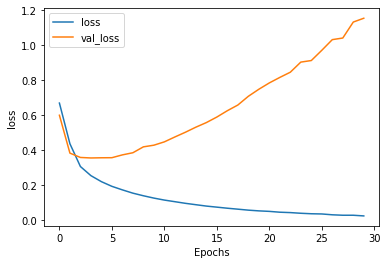

In [29]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "loss")

In [33]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(np.around(model.predict(padded)))

[[1.]
 [0.]]


Embedding files (vecs and meta)

In [30]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 16)


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')